Julia is a language meant for working with data. In that regard, we would like to be able to be able to
perform analyses like linear regression and hypothesis testing. We would also like to perform more complex operations
including building neural networks and running algorithms. Thankfully, there are packages that allow us to easily perform these tasks.

In this presentation, I will be focusing on three different packages; MLJ.jl, Graphs.jl, and JuMP.jl.

MLJ.jl is a high-level machine learning framework, while Graphs.jl is meant for network analysis. JuMP.jl is a mathematical optimization framework.

MLJ is a machine learning package that is similar to Python's scikit-learn, due to its breadth and flexibility in performing different
kinds of analyses.

In [1]:
using Pkg
Pkg.add(["MLJ", "MLJLinearModels", "DataFrames", "StatsBase"])

   Resolving package versions...
  No Changes to `C:\Users\joshu\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\joshu\.julia\environments\v1.11\Manifest.toml`


There are numerous models we can configure and implement for many different machine learning problems, as shown by listing out the possible models.


In [2]:
using MLJ
models()

234-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :constructor, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :target_in_fit, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = ABODDetector, package_name = OutlierDetectionNeighbors, ... )
 (name = ABODDetector, package_name = OutlierDetectionPython, ... )
 (name = ARDRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = AdaBoostClassifier, package_name = MLJScikitLearnInterface, ... )
 (name = AdaBoostRegressor, package_name = MLJScikitLearnInterfa

One example that we can look at is implementing linear regression on the Boston housing dataset. We would like to model the prices of properties as functions of the other variables.

We start by loading the dataset and then dividing the data into training and testing data. This can be done without any external tools.

In [25]:
using MLJ, DataFrames, MLJLinearModels, StatsBase

# Load dataset
X, y = @load_boston

# Convert X to a DataFrame
X = DataFrame(X)

# Split data into training (80%) and test (20%) sets
train, test = partition(eachindex(y), 0.8, shuffle=true)
X_train, X_test = X[train, :], X[test, :]
y_train, y_test = y[train], y[test]

([23.4, 21.2, 5.0, 18.9, 16.1, 19.4, 28.1, 19.7, 6.3, 9.5  …  17.8, 17.5, 11.9, 36.0, 29.6, 50.0, 18.2, 32.4, 23.0, 33.4], [20.9, 24.6, 23.9, 22.9, 23.1, 10.9, 22.1, 25.0, 11.8, 24.5  …  50.0, 13.1, 25.2, 17.2, 14.8, 22.0, 11.0, 21.4, 21.4, 33.0])

Now, we load an MLJ model. Specifically, we will use LinearRegressor, which is a simple linear regression model. MLJ offers other alternatives, including RidgeRegressor and LassoRegressor, as well as linear model classifiers like LogisticClassifier.

In [4]:
# Load Linear Regression model
@load LinearRegressor pkg=MLJLinearModels
model = LinearRegressor()

# Create a machine (model + data)
mach = machine(model, X_train, y_train)

# Train the model
fit!(mach)

[ Info: For silent loading, specify `verbosity=0`. 


import MLJLinearModels ✔


[ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
┌ Info: Solver: Analytical
│   iterative: Bool false
└   max_inner: Int64 200


trained Machine; caches model-specific representations of data
  model: LinearRegressor(fit_intercept = true, …)
  args: 
    1:	Source @471 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @640 ⏎ AbstractVector{Continuous}


After fitting the model, we can now make predictions to see how accurate our model is! We can use the StatsBase package to calculate metrics like R-squared and MAE.

In [35]:
# Make predictions
y_pred = MLJ.predict(mach, X_test)

r2_score = cor(y_pred_numeric, y_test)^2
mae_score = mean(abs.(y_pred_numeric - y_test))

println("R² Score: ", r2_score)
println("MAE: ", mae_score)

R² Score: 0.7778171789206735
MAE: 3.5654545702415246


On the other hand, if you are interested in solving problems with deep learning techniques, Flux.jl is a popular option for that. Flux is a deep learning framework that has a lot of the same functionalities as MLJ, but is more focused on deep learning and allowing the user to control those areas of computation.

MLJ is more suited towards high-level implementations. It supports diverse approaches to problems, and allows users to pull together and integrate multiple models, without requiring low-level mastery. However, it does not inherently support GPU acceleration, which makes it slower when running large tasks.

The last two packages I want to go over are Graphs.jl and JuMP.jl. While MLJ and Flux are meant for machine learning, there may be times when a user is interested in implementing optimization algorithms, like Dijkstra's or Simplex. These algorithms are of a different flavor as they are not necessarily meant to solve prediction or inference problems, but are many times useful for finding optimal paths or augmentations for a specific task.

We can see how Graphs.jl can be useful through an implementation of Dijkstra's Algorithm.

Below is a raw implementation of the algorithm on a simple graph, with no external packages being used.

In [6]:
function dijkstra(graph::Dict{Int, Dict{Int, Int}}, start::Int)
    # Initialize distances to infinity, except for the start node
    dist = Dict(k => Inf for k in keys(graph))
    dist[start] = 0

    # Track visited nodes
    visited = Dict(k => false for k in keys(graph))

    # Track shortest paths
    prev = Dict{Int, Union{Nothing, Int}}(k => nothing for k in keys(graph))

    while true
        # Select the unvisited node with the smallest distance
        u = nothing
        for node in keys(graph)
            if !visited[node] && (u === nothing || dist[node] < dist[u])
                u = node
            end
        end

        # Stop if there are no reachable unvisited nodes
        if u === nothing || dist[u] == Inf
            break
        end

        # Mark node as visited
        visited[u] = true

        # Update distances to neighbors
        for (v, weight) in graph[u]
            alt = dist[u] + weight
            if alt < dist[v]
                dist[v] = alt
                prev[v] = u
            end
        end
    end

    return dist, prev
end

# Function to reconstruct the shortest path
function shortest_path(prev::Dict{Int, Union{Nothing, Int}}, target::Int)
    path = []
    while target !== nothing
        pushfirst!(path, target)
        target = prev[target]
    end
    return path
end

# Define a weighted graph using a properly typed dictionary
graph = Dict{Int, Dict{Int, Int}}(
    1 => Dict(2 => 4, 3 => 1),
    2 => Dict(4 => 1),
    3 => Dict(2 => 2, 4 => 5),
    4 => Dict(5 => 3),
    5 => Dict()
)

# Run Dijkstra's algorithm from node 1
distances, predecessors = dijkstra(graph, 1)

# Print shortest distance from node 1 to 5
println("Shortest distance from 1 to 5: ", distances[5])

# Get the shortest path from node 1 to 5
path = shortest_path(predecessors, 5)
println("Shortest path from 1 to 5: ", path)

Shortest distance from 1 to 5: 7.0
Any[1, 3, 2, 4, 5] 1 to 5: 


The code is quite bulky and requires a lot of work to develop. By using the Graphs package, we can implement a shorter, more elegant solution to the same problem.

In [7]:
using Pkg
Pkg.add("Graphs")
using Graphs

   Resolving package versions...
  No Changes to `C:\Users\joshu\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\joshu\.julia\environments\v1.11\Manifest.toml`


In [8]:
# Create a directed graph with 5 nodes
g = SimpleDiGraph(5)

# Define weighted edges
edges = [
    (1, 2, 4), (1, 3, 1),
    (3, 2, 2), (3, 4, 5),
    (2, 4, 1), (4, 5, 3)
]

# Add edges to the graph
for (u, v, _) in edges
    add_edge!(g, u, v)  # Add edge
end

# Create a weight matrix (initialize with Inf)
weights = fill(Inf, nv(g), nv(g))

# Assign weights to the adjacency matrix
for (u, v, w) in edges
    weights[u, v] = w
end

# Run Dijkstra's Algorithm from node 1
result = dijkstra_shortest_paths(g, 1, weights)

# Get the shortest path distance to node 5
println("Shortest distance from node 1 to 5: ", result.dists[5])

# Retrieve the shortest path to node 5
function get_path(result, target)
    path = []
    while target != 0
        pushfirst!(path, target)
        target = result.parents[target]
    end
    return path
end

best_path = get_path(result, 5)
println("Shortest path from node 1 to 5: ", best_path)


Shortest distance from node 1 to 5: 7.0
Shortest path from node 1 to 5: Any[1, 3, 2, 4, 5]


We can see that the Graphs package is quite useful for the representation of non-numeric objects. Networks are the foundation of many important problems, and combining them with the numerical computing power of Julia can help to solve many problems.

Finally, we will go over a mathematical optimization framework called JuMP.jl, as well as a mathematical solver package called Gurobi. Mathematical optimization is at the core of many different problems like portfolio optimization, control theory, and other various fields. Being able to solve optimization problems as fast as possible carries a lot of importance in fields like supply chain logistics, asset allocation, etc.

JuMP works within Julia but acts like its own language. By defining objects like objective functions and constraints, JuMP becomes a versatile tool for constructing and solving problems like Linear Programs, Quadratic Programs, and Mixed Integer Optimization problems.

On the flip side, solvers like Gurobi are the workhorses for solving these problems. Gurobi in particular is the world's fastest mathematical solver, due to its ability to adjust its solving strategies to each problem as well as the extreme level of care put into optimizing each process through parallel computing and fast code.

Gurobi is also free for academics!

In [30]:
Pkg.add("JuMP")
Pkg.add("Gurobi")
Pkg.add("MathOptInterface")

   Resolving package versions...
  No Changes to `C:\Users\joshu\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\joshu\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\joshu\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\joshu\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\joshu\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\joshu\.julia\environments\v1.11\Manifest.toml`


In [31]:
using JuMP, Gurobi, MathOptInterface
env = Gurobi.Env()

Set parameter Username
Set parameter LicenseID to value 2630108
Academic license - for non-commercial use only - expires 2026-03-02


Gurobi.Env(Ptr{Nothing} @0x000001b379515120, false, 0)

In [11]:
# Define a JuMP model with Gurobi as the solver
model = JuMP.Model(Gurobi.Optimizer)

Set parameter Username
Set parameter LicenseID to value 2630108
Academic license - for non-commercial use only - expires 2026-03-02


A JuMP Model
├ solver: Gurobi
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

Let's say that we have a problem of the form:

$$
\displaystyle\max_{x_1,x_2} 5x_1 + 4x_2
$$

With the constraints:

$$
\displaystyle 6x_1 + 4x_2 ≤ 24
$$
$$
\displaystyle x_1 + 2x_2 ≤ 6
$$
$$
\displaystyle x_1, x_2 ≥ 0
$$

We can define this problem with JuMP and subsequently solve!

In [12]:
# Define variables (x1, x2 >= 0)
@variable(model, x1 >= 0)
@variable(model, x2 >= 0)

# Objective function: Maximize 5x1 + 4x2
@objective(model, Max, 5x1 + 4x2)

# Constraints
@constraint(model, 6x1 + 4x2 <= 24)
@constraint(model, x1 + 2x2 <= 6)

# Solve the optimization problem
optimize!(model)

# Display results
println("Optimal x1 = ", value(x1))
println("Optimal x2 = ", value(x2))
println("Optimal objective value = ", objective_value(model))

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x9f631cdb
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [4e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+01]
Presolve time: 0.01s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.0000000e+30   2.750000e+30   9.000000e+00      0s
       2    2.1000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.100000000e+01

User-callback calls 47, time in user-callback 0.00 sec
Optimal x1 = 3.0
Optimal x2 = 1.5
Optimal objective value = 21.0


JuMP can also be used to solve other genres of optimization problems. For example, let us consider an MIO problem of the form:

$$
\displaystyle \max_{x_1,x_2} 2x_1 + 3x_2
$$

$$
\displaystyle 4x_1 + 3x_2 ≤ 12
$$

$$
\displaystyle 2x_1 + x_2 ≤ 6
$$

$$
\displaystyle x_1, x_2 ≥ 0
$$

$$
\displaystyle x_1, x_2 ∈ ℤ
$$

In [13]:
using JuMP, Gurobi

model = JuMP.Model(Gurobi.Optimizer)

@variable(model, x1 >= 0, Int) # Must specify as Int
@variable(model, x2 >= 0, Int) # Must specify as Int

@objective(model, Max, 2x1 + 3x2)

@constraint(model, 4x1 + 3x2 <= 12)
@constraint(model, 2x1 + x2 <= 6)

optimize!(model)

println("Optimal x1 = ", value(x1))
println("Optimal x2 = ", value(x2))
println("Optimal objective value = ", objective_value(model))

Set parameter Username
Set parameter LicenseID to value 2630108
Academic license - for non-commercial use only - expires 2026-03-02
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0xb17432a7
Variable types: 0 continuous, 2 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [2e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+01]
Found heuristic solution: objective 6.0000000
Presolve removed 2 rows and 2 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 12 6 

Optimal solution found

We can try a large problem. MIO is an especially difficult problem to solve, and when we have a lot of variables and constraints to fulfill, it can take more and more time to solve. JuMP and Gurobi offer functionalities useful in working around potentially nasty problems; we can adjust the number of the threads being used, and we can tell the solver that we are willing to accept certain levels of optimality gaps, in order to speed up solving.

In [15]:
using JuMP, Gurobi, Random

# Use MOI directly from MathOptInterface (no need to redefine it)
Random.seed!(42)

# Create the model using Gurobi
model = JuMP.Model(Gurobi.Optimizer)

# Problem size parameters
num_int_vars = 300  # Integer variables
num_bin_vars = 150  # Binary variables
num_constraints = 500  # Total constraints

# Generate random coefficients ensuring feasibility & boundedness
c = rand(10:100, num_int_vars)      # Objective coefficients for x
d = rand(5:50, num_bin_vars)        # Objective coefficients for y
e = rand(1:5, num_int_vars)         # Small penalty to prevent unbounded solutions
a = rand(1:5, num_constraints, num_int_vars)  # Constraint coefficients for x (smaller values)
b = rand(1:3, num_constraints, num_bin_vars)  # Constraint coefficients for y (smaller values)
k = sum(a, dims=2)[:, 1] * 50 + sum(b, dims=2)[:, 1] * 1  # Ensures feasibility

# Define integer variables (1 ≤ x_i ≤ 100, x_i ∈ ℤ)
@variable(model, 1 <= x[1:num_int_vars] <= 100, Int)

# Define binary variables (y_j ∈ {0,1})
@variable(model, y[1:num_bin_vars], Bin)

# Define the objective function (maximize Z)
@objective(model, Max, 
    sum(c[i] * x[i] for i in 1:num_int_vars) +
    sum(d[j] * y[j] for j in 1:num_bin_vars) - 
    sum(e[i] * x[i]^2 for i in 1:num_int_vars)  # Small quadratic penalty to ensure boundedness
)

# Add constraints ensuring feasibility
for j in 1:num_constraints
    @constraint(model, 
        sum(a[j, i] * x[i] for i in 1:num_int_vars) +
        sum(b[j, j] * y[j] for j in 1:num_bin_vars) <= k[j]
    )
end

# Increase solver difficulty while keeping it feasible
set_optimizer_attribute(model, "TimeLimit", 120)  # Give Gurobi 2 minutes
set_optimizer_attribute(model, "MIPGap", 0.02)  # Allow 2% optimality gap
# set_optimizer_attribute(model, "Threads", 1)  # Single-threaded (slows down solving)
# set_optimizer_attribute(model, "Presolve", 2)  # Enable presolve for better performance
# set_optimizer_attribute(model, "Cuts", 1)  # Allow cuts to help find solutions

# Solve the problem and track time
@time optimize!(model)

println("Optimal Objective Value: ", objective_value(model))
println("First 10 integer variable values: ", [value(x[i]) for i in 1:10])
println("First 10 binary variable values: ", [value(y[j]) for j in 1:10])

Set parameter Username
Set parameter LicenseID to value 2630108
Academic license - for non-commercial use only - expires 2026-03-02
Set parameter TimeLimit to value 120
Set parameter MIPGap to value 0.02
Set parameter MIPGap to value 0.02
Set parameter TimeLimit to value 120
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  120
MIPGap  0.02

Optimize a model with 500 rows, 450 columns and 225000 nonzeros
Model fingerprint: 0xe3ee7d39
Model has 300 quadratic objective terms
Variable types: 0 continuous, 450 integer (150 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [5e+00, 1e+02]
  QObjective range [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [4e+04, 5e+04]
Found heuristic solution: obje

Finally, let's look at an application of JuMP to a more realistic problem. We will look at the Traveling Salesman Problem, where we want to find the shortest route that visits all nodes . This problem is notoriously difficult to solve because there are so many candidate solutions. 

Set parameter Username
Set parameter LicenseID to value 2630108
Academic license - for non-commercial use only - expires 2026-03-02
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9902 rows, 10099 columns and 48906 nonzeros
Model fingerprint: 0x325090e3
Variable types: 99 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [7e-03, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 0 rows and 100 columns
Presolve time: 0.10s
Presolved: 9902 rows, 9999 columns, 48906 nonzeros
Variable types: 99 continuous, 9900 integer (9900 binary)

Root relaxation: objective 6.147645e+00, 328 iterations, 0.04 seconds (0.01 work units)

    Nodes    |    Current Node    

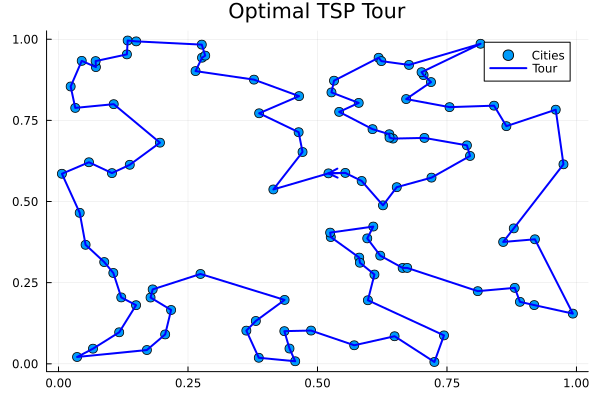

In [21]:
using JuMP, Gurobi, Plots, Random

# Function to generate random city coordinates
function generate_cities(n, seed=123)
    Random.seed!(seed)
    return [(rand(), rand()) for _ in 1:n]
end

# Compute Euclidean distance matrix
function compute_distance_matrix(cities)
    n = length(cities)
    dist_matrix = zeros(n, n)
    for i in 1:n, j in 1:n
        dist_matrix[i, j] = hypot(cities[i][1] - cities[j][1], cities[i][2] - cities[j][2])
    end
    return dist_matrix
end

# Solve TSP using JuMP and Gurobi
function solve_tsp(dist_matrix)
    n = size(dist_matrix, 1)
    model = JuMP.Model(Gurobi.Optimizer)

    @variable(model, x[1:n, 1:n], Bin)

    # Objective: Minimize travel distance
    @objective(model, Min, sum(dist_matrix[i, j] * x[i, j] for i in 1:n, j in 1:n))

    # Constraints: Each city must be entered and exited exactly once
    @constraint(model, [i in 1:n], sum(x[i, j] for j in 1:n if i != j) == 1)
    @constraint(model, [j in 1:n], sum(x[i, j] for i in 1:n if i != j) == 1)

    # Subtour elimination (MTZ formulation)
    @variable(model, u[2:n] >= 0)
    @constraint(model, [i in 2:n, j in 2:n; i != j],
                u[i] - u[j] + n * x[i, j] ≤ n - 1)

    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        println("Optimal tour found with cost: ", objective_value(model))
        tour = Dict{Int, Int}()
        for i in 1:n, j in 1:n
            if value(x[i, j]) > 0.5
                tour[i] = j
            end
        end
        return tour
    else
        println("No optimal solution found.")
        return nothing
    end
end

# Function to extract the ordered tour from the dictionary
function get_tour_sequence(tour)
    if tour === nothing
        return []
    end
    n = length(tour)
    sequence = [1]  # Start from node 1
    while length(sequence) < n
        sequence = push!(sequence, tour[sequence[end]])
    end
    push!(sequence, 1)  # Return to the starting city
    return sequence
end

# Function to plot the TSP solution
function plot_tsp(cities, tour_sequence)
    x_vals = [cities[i][1] for i in tour_sequence]
    y_vals = [cities[i][2] for i in tour_sequence]

    scatter([c[1] for c in cities], [c[2] for c in cities], label="Cities", markersize=5)
    plot!(x_vals, y_vals, arrow=true, label="Tour", linewidth=2, color=:blue)
    title!("Optimal TSP Tour")
end

# Generate cities and solve TSP
n = 100  # Number of cities
cities = generate_cities(n)
dist_matrix = compute_distance_matrix(cities)
tour = solve_tsp(dist_matrix)

# Plot the solution if found
if tour !== nothing
    tour_sequence = get_tour_sequence(tour)
    plot_tsp(cities, tour_sequence)
end


In [23]:
# We can check whether the solution is optimal or not.
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

In [28]:
# Solve TSP using JuMP and Gurobi
function suboptimal_tsp(dist_matrix)
    n = size(dist_matrix, 1)
    model = JuMP.Model(Gurobi.Optimizer)

    @variable(model, x[1:n, 1:n], Bin)

    # Objective: Minimize travel distance
    @objective(model, Min, sum(dist_matrix[i, j] * x[i, j] for i in 1:n, j in 1:n))

    # Constraints: Each city must be entered and exited exactly once
    @constraint(model, [i in 1:n], sum(x[i, j] for j in 1:n if i != j) == 1)
    @constraint(model, [j in 1:n], sum(x[i, j] for i in 1:n if i != j) == 1)

    # Subtour elimination (MTZ formulation)
    @variable(model, u[2:n] >= 0)
    @constraint(model, [i in 2:n, j in 2:n; i != j],
                u[i] - u[j] + n * x[i, j] ≤ n - 1)

    set_optimizer_attribute(model, "MIPGap", 0.1)  # Allow 10% optimality gap

    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        println("Optimal tour found with cost: ", objective_value(model))
        tour = Dict{Int, Int}()
        for i in 1:n, j in 1:n
            if value(x[i, j]) > 0.5
                tour[i] = j
            end
        end
        return tour
    else
        println("No optimal solution found.")
        return nothing
    end
end

suboptimal_tsp (generic function with 1 method)

Set parameter Username
Set parameter LicenseID to value 2630108
Academic license - for non-commercial use only - expires 2026-03-02
Set parameter MIPGap to value 0.1
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0.1

Optimize a model with 9902 rows, 10099 columns and 48906 nonzeros
Model fingerprint: 0x325090e3
Variable types: 99 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [7e-03, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 0 rows and 100 columns
Presolve time: 0.20s
Presolved: 9902 rows, 9999 columns, 48906 nonzeros
Variable types: 99 continuous, 9900 integer (9900 binary)

Root relaxation: o

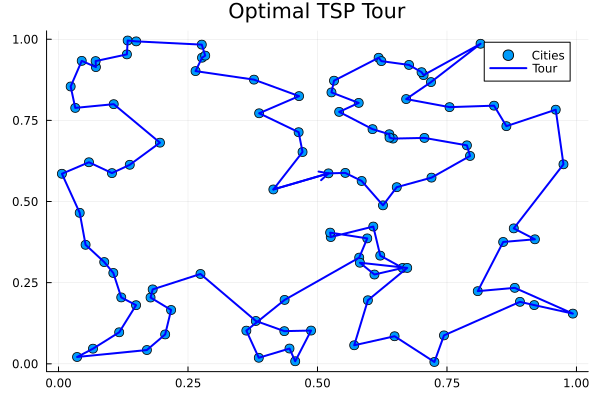

In [29]:
# Generate cities and solve TSP
n = 100  # Number of cities
cities = generate_cities(n)
dist_matrix = compute_distance_matrix(cities)
tour = suboptimal_tsp(dist_matrix)

# Plot the solution if found
if tour !== nothing
    tour_sequence = get_tour_sequence(tour)
    plot_tsp(cities, tour_sequence)
end


Unfortunately, JuMP does not support GPU acceleration, but some solvers do! However, GPUs are generally not well-suited for many of the problems that JuMP was built to solve. This is because problems like linear programs do not have thousands of processes to be run at the same time.